# Image classifier

In [3]:
!pip install torch
!pip install torchvision

In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB,CategoricalNB
import matplotlib.pyplot as plt

C:\Users\ASUS\anaconda3\envs\mnist_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
# converts a picture into normalized vector with values [0,1]
# more info here https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
transformer = transforms.Compose([
                               torchvision.transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)),
#                                transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])

In [3]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= (int)(len(train_set)/10)
batch_size_test=len(test_set)

26422272it [00:42, 619442.36it/s]                                                                                      


Extracting ./files/fashion-mnist/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



29696it [00:00, 1331530.77it/s]                                                                                        


Extracting ./files/fashion-mnist/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



4422656it [00:02, 1565245.36it/s]                                                                                      


Extracting ./files/fashion-mnist/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



6144it [00:00, 4200457.01it/s]                                                                                         

Extracting ./files/fashion-mnist/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



In [4]:
train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

In [5]:
train_enumerated = enumerate(train_loader)
batch_idx, (train_x, train_y) = next(train_enumerated)

test_enumerated = enumerate(test_loader)
batch_idx, (test_x, test_y) = next(test_enumerated)

In [6]:
train_x.shape

torch.Size([6000, 784])

In [7]:
# 

# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(train_x[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(train_y[i]))
#   plt.xticks([])
#   plt.yticks([])
# fig

In [8]:
train_x[1].shape

torch.Size([784])

## Models
### Comparing the models

We will make a cross validation for the four models and compare them.

In [9]:
# K-Fold Cross-Validation

def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [10]:
# # Grouped Bar Chart for both training and validation data
# def plot_result(x_label, y_label, plot_title, train_data, val_data):
#         '''Function to plot a grouped bar chart showing the training and validation
#           results of the ML model in each fold after applying K-fold cross-validation.
#          Parameters
#          ----------
#          x_label: str, 
#             Name of the algorithm used for training e.g 'Decision Tree'
          
#          y_label: str, 
#             Name of metric being visualized e.g 'Accuracy'
#          plot_title: str, 
#             This is the title of the plot e.g 'Accuracy Plot'
         
#          train_result: list, array
#             This is the list containing either training precision, accuracy, or f1 score.
        
#          val_result: list, array
#             This is the list containing either validation precision, accuracy, or f1 score.
#          Returns
#          -------
#          The function returns a Grouped Barchart showing the training and validation result
#          in each fold.
#         '''
        
#         # Set size of plot
#         plt.figure(figsize=(12,6))
#         labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
#         X_axis = np.arange(len(labels))
#         ax = plt.gca()
#         plt.ylim(0.40000, 1)
#         plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
#         plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
#         plt.title(plot_title, fontsize=30)
#         plt.xticks(X_axis, labels)
#         plt.xlabel(x_label, fontsize=14)
#         plt.ylabel(y_label, fontsize=14)
#         plt.legend()
#         plt.grid(True)
#         plt.show()

In [12]:
# cross_validation(model, train_x, train_y, _cv=5)

In [13]:
# cross_validate(model,X=train_x,y=train_y,cv=10)

In [14]:
model_lbls = [
              'gnb', 
              'mnb', 
              'cnb', 
              'bnb', 
#              'catnb',
            ]

models = {
    'gnb': {'name': 'Gaussian Naive Bayes       ',
           'estimator': GaussianNB(), 
           'param': [{}],
          },
    'mnb': {'name': 'Multinomial Naive Bayes       ',
           'estimator': MultinomialNB(),
           'param': [{}]
          },
    'cnb': {'name': 'ComplementNB   ',
           'estimator': ComplementNB(),
           'param': [{}],
          },
    'bnb':{'name': 'BernoulliNB      ',
           'estimator': BernoulliNB(), 
           'param': [{}]
          },
#     'catnb':{'name': 'CategoricalNB ',
#            'estimator': CategoricalNB(),
#            'param': [{}]
        
#     }
}

scores = ['precision', 'recall']

In [15]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    true_y, pred_y = test_y, model.predict(test_x)
    print(classification_report(true_y, pred_y))
    print()

In [16]:

def evaluate_models(models):
    results_short = {}
    for score in scores:
        print('='*40)
        print("# Tuning hyper-parameters for %s" % score)
        print()

        #'%s_macro' % score ## is a string formatting expression
        # the parameter after % is substituted in the string placeholder %s
        for m in model_lbls:
            print('-'*40)
            print("Trying model {}".format(models[m]['name']))
            clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv=5,
                               scoring='%s_macro' % score, 
    #                            iid = False, 
                               return_train_score = False,
                               n_jobs = 2, # this allows using multi-cores
                               )
            clf.fit(train_x, train_y)
            print_results(clf)
            results_short[m] = clf.best_score_
        print("Summary of results for {}".format(score))
        print("Estimator")
        for m in results_short.keys():
            print("{}\t - score: {:4.2}%".format(models[m]['name'], results_short[m]))

In [17]:
evaluate_models(models)

# Tuning hyper-parameters for precision

----------------------------------------
Trying model Gaussian Naive Bayes       
Best parameters set found on train set:

{}

Grid scores on train set:

0.586 (+/-0.028) for {}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      1000
           1       0.43      0.97      0.60      1000
           2       0.58      0.39      0.47      1000
           3       0.21      0.13      0.16      1000
           4       0.42      0.70      0.53      1000
           5       0.85      0.29      0.44      1000
           6       0.30      0.04      0.07      1000
           7       0.48      0.98      0.65      1000
           8       0.83      0.70      0.76      1000
           9       0.94      0.57      0.71      1000

    accuracy                     

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1000
           1       0.94      0.90      0.92      1000
           2       0.49      0.65      0.56      1000
           3       0.64      0.81      0.72      1000
           4       0.47      0.51      0.49      1000
           5       0.98      0.67      0.80      1000
           6       0.35      0.12      0.18      1000
           7       0.69      0.89      0.77      1000
           8       0.86      0.83      0.84      1000
           9       0.82      0.87      0.84      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000


Summary of results for recall
Estimator
Gaussian Naive Bayes       	 - score: 0.54%
Multinomial Naive Bayes       	 - score: 0.67%
ComplementNB   	 - score: 0.59%
BernoulliNB      	 - score: 0.71%


As we can see the Multinomial Naive Bayes and the Bernoulli Naive Bayes outperform the other two classifiers.
That's why we will take a closer look at these two and try to pick the best parameters.

In [18]:
models = {
    'mnb': {'name': 'Multinomial Naive Bayes       ',
           'estimator': MultinomialNB(),
           'param': [{'alpha': [0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],}]
          },
    'bnb':{'name': 'BernoulliNB      ',
           'estimator': BernoulliNB(), 
           'param': [{'alpha': [0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],

'binarize' :[ None,0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],
}]
          },
}

model_lbls = [
          
              'mnb', 
       
              'bnb', 
#              'catnb',
            ]

In [19]:
evaluate_models(models)

# Tuning hyper-parameters for precision

----------------------------------------
Trying model Multinomial Naive Bayes       
Best parameters set found on train set:

{'alpha': 30}

Grid scores on train set:

0.659 (+/-0.030) for {'alpha': 0}
0.660 (+/-0.028) for {'alpha': 0.1}
0.660 (+/-0.029) for {'alpha': 0.3}
0.660 (+/-0.029) for {'alpha': 0.5}
0.659 (+/-0.029) for {'alpha': 0.75}
0.659 (+/-0.029) for {'alpha': 1}
0.659 (+/-0.029) for {'alpha': 2}
0.663 (+/-0.032) for {'alpha': 3}
0.664 (+/-0.033) for {'alpha': 4}
0.671 (+/-0.039) for {'alpha': 10}
0.678 (+/-0.027) for {'alpha': 20}
0.680 (+/-0.020) for {'alpha': 30}
0.674 (+/-0.029) for {'alpha': 50}
0.601 (+/-0.052) for {'alpha': 100}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1000
           1       0.98      0.89      

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1000
           1       0.97      0.89      0.93      1000
           2       0.54      0.65      0.59      1000
           3       0.68      0.83      0.75      1000
           4       0.48      0.54      0.51      1000
           5       0.94      0.76      0.84      1000
           6       0.32      0.13      0.19      1000
           7       0.76      0.90      0.82      1000
           8       0.88      0.90      0.89      1000
           9       0.88      0.89      0.89      1000

    accuracy                           0.73     10000
   macro avg       0.71      0.73      0.71     10000
weighted avg       0.71      0.73      0.71     10000


Summary of results for precision
Estimator
Multinomial Naive Bayes       	 - score: 0.68%
BernoulliNB      	 - score: 0.73%
# Tuning hyper-parameters for recall

----------------------------------------
Trying model Multinomial Naive Bayes 

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1000
           1       0.97      0.89      0.93      1000
           2       0.54      0.65      0.59      1000
           3       0.68      0.83      0.75      1000
           4       0.48      0.54      0.51      1000
           5       0.94      0.76      0.84      1000
           6       0.32      0.13      0.19      1000
           7       0.76      0.90      0.82      1000
           8       0.88      0.90      0.89      1000
           9       0.88      0.89      0.89      1000

    accuracy                           0.73     10000
   macro avg       0.71      0.73      0.71     10000
weighted avg       0.71      0.73      0.71     10000


Summary of results for recall
Estimator
Multinomial Naive Bayes       	 - score: 0.67%
BernoulliNB      	 - score: 0.74%


### Tuning the best models

We will try to make a better decision abot our parameters.

In [20]:
def plot_scores_by_parameter(model,ks,X_train,X_test,y_train,y_test,visualize=True):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = model(k).fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(ks, train_scores, color='blue', label='train score')
        plt.plot(ks, test_scores, color='green', label='test score')
        plt.legend()
    return train_scores,test_scores

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, random_state=0)

#### Multinomial Naive Bayes

In [22]:
mnb_constructor = lambda a: MultinomialNB(alpha=a)

([0.6653333333333333,
  0.6648888888888889,
  0.6651111111111111,
  0.6651111111111111,
  0.6644444444444444,
  0.6637777777777778,
  0.6624444444444444,
  0.662,
  0.6615555555555556,
  0.6591111111111111,
  0.6555555555555556,
  0.6531111111111111,
  0.6455555555555555,
  0.6326666666666667],
 [0.6713333333333333,
  0.6726666666666666,
  0.672,
  0.672,
  0.672,
  0.6726666666666666,
  0.672,
  0.6726666666666666,
  0.6726666666666666,
  0.6733333333333333,
  0.6693333333333333,
  0.6653333333333333,
  0.6593333333333333,
  0.6573333333333333])

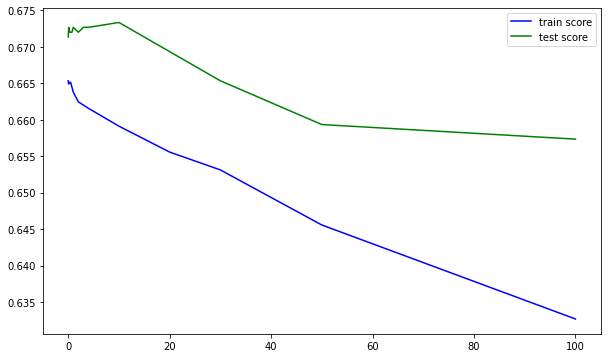

In [23]:
plot_scores_by_parameter(mnb_constructor,[0,0.1,0.3,0.5,0.75,1,2,3,4,10,20,30,50,100],X_train,X_valid,y_train,y_valid)

The best results are between 0 and 1. So we will try the experiment again with smaller numbers.

([0.6653333333333333,
  0.6648888888888889,
  0.6648888888888889,
  0.6651111111111111,
  0.6651111111111111,
  0.6651111111111111,
  0.6651111111111111,
  0.6651111111111111,
  0.6651111111111111,
  0.6651111111111111,
  0.6651111111111111,
  0.6648888888888889,
  0.6646666666666666,
  0.6644444444444444,
  0.6644444444444444,
  0.6644444444444444,
  0.6644444444444444,
  0.6642222222222223,
  0.664,
  0.664,
  0.6637777777777778,
  0.6631111111111111,
  0.6631111111111111,
  0.6628888888888889,
  0.6626666666666666,
  0.6626666666666666,
  0.6626666666666666,
  0.6622222222222223,
  0.6622222222222223,
  0.6622222222222223,
  0.6622222222222223,
  0.6624444444444444,
  0.6622222222222223,
  0.6622222222222223,
  0.6622222222222223,
  0.6622222222222223,
  0.6622222222222223,
  0.662,
  0.6624444444444444,
  0.6624444444444444],
 [0.6713333333333333,
  0.672,
  0.6726666666666666,
  0.6726666666666666,
  0.6726666666666666,
  0.672,
  0.672,
  0.672,
  0.672,
  0.672,
  0.672,
  0.672

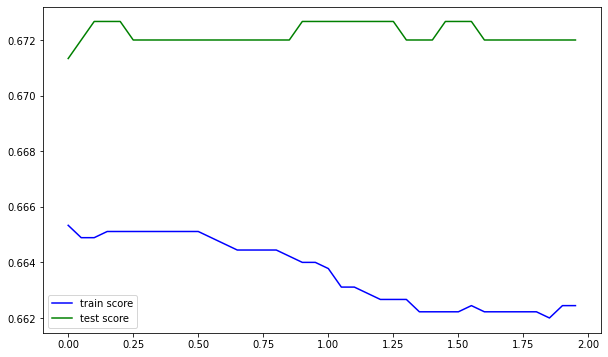

In [24]:
plot_scores_by_parameter(mnb_constructor,np.arange(0,2,0.05),X_train,X_valid,y_train,y_valid)

In [ ]:
plot_scores_by_parameter(mnb_constructor,np.arange(0,0.2,0.001),X_train,X_valid,y_train,y_valid)

The best value for alpha is 0.025.

#### Bernoulli Naive Bayes

Now we will do the same for BernoulliNB. From the previous experiments with the parameters we now that alpha must be around 0 and binarize around 0.1.

In [ ]:
bnb_by_alpha_constructor = lambda a: BernoulliNB(alpha=a,binarize=0.5)
bnb_by_binarize_constructor = lambda b: BernoulliNB(alpha=0,binarize=b)
bnb_constructor = lambda l: BernoulliNB(alpha=l[0],binarize=l[1])

In [ ]:
_=plot_scores_by_parameter(bnb_by_alpha_constructor,np.arange(0,2,0.05),X_train,X_valid,y_train,y_valid)

As we can see the best value for alpha is 0.

In [ ]:
_=plot_scores_by_parameter(bnb_by_binarize_constructor,np.arange(0,2,0.05),X_train,X_valid,y_train,y_valid)

In [ ]:
_=plot_scores_by_parameter(bnb_by_binarize_constructor,np.arange(0,0.9,0.1),X_train,X_valid,y_train,y_valid)

In [ ]:
_=plot_scores_by_parameter(bnb_by_binarize_constructor,np.arange(0.1,0.6,0.05),X_train,X_valid,y_train,y_valid)

The best value for binarize is around 0.3.
Now we will try the model with values for alpha and binarize which are close to teh already found ones.

In [ ]:
values=[(0,0.1),(0,0.2),(0,0.3),(0,0.4),(0,0.5),(0,0.6),(0.1,0.1),(0.1,0.2),(0.1,0.3),(0.1,0.4),(0.1,0.5),(0.1,0.6)]
train_scores,test_scores = plot_scores_by_parameter(bnb_constructor,values,X_train,X_valid,y_train,y_valid,visualize=False)

In [ ]:
for value,train_score,test_score in zip(values,train_scores,test_scores):
    print(f'alpha={value[0]} binarize={value[1]}, train score: {train_score}, test_score: {test_score}')

This experiment confirms our previoues results. The best values are alpha=0, binarize=0.3

### Final tests
Let's test our tuned models on the test data.

In [ ]:
bnb = BernoulliNB(alpha=0, binarize=0.3)
mnb= MultinomialNB(alpha=0.025)

bnb.fit(train_x,train_y)
mnb.fit(train_x,train_y)
# Perform the predictions
bnb_pred = bnb.predict(test_x)
mnb_pred = mnb.predict(test_x)
# Calculate the accuracy of the prediction

print (f'BernoulliNB Accuracy = {accuracy_score(test_y, bnb_pred)*100}')
print (f'MultinomialNB Accuracy = {accuracy_score(test_y, mnb_pred)*100}')
# Cross validate the scores

print (f'BernoulliNB Classification Report \n {classification_report(test_y, bnb_pred, labels=range(0,10))}')
print (f'MultinomialNB Classification Report \n {classification_report(test_y, mnb_pred, labels=range(0,10))}')

BernoulliNB is the best classifier for this dataset.